<a href="https://colab.research.google.com/github/keskinyasir/Anomaly_Detection/blob/main/S%26P500_Anomaly_Detection_Time_Series_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h2 align=center>S&P500 Anomaly Detection in Time Series with Keras</h2>


## Task 1: Project Overview and Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.1


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [2]:
sandp500=pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['date'])
sandp500.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [3]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=sandp500['date'], y=sandp500['close'], mode='lines', name='close'))
fig.update_layout(showlegend=True)
fig.show()

In [4]:
train_s = int(len(sandp500)*0.8)
test_s = len(sandp500) - train_s
train, test = sandp500.iloc[0:train_s],sandp500.iloc[train_s:len(sandp500)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


## Task 3: Data Preprocessing

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_fit = scaler.fit(train[['close']]) # two '[[]]' because output must data frame, otherwise(one '[]') output is series
train['close'] = scaler_fit.transform(train[['close']])
test['close'] = scaler_fit.transform(test[['close']])

## Task 4: Create Training and Test Splits

In [6]:
def create_sequence(x, y, time_steps=1):
  xs, ys = [], []
  for n in range(len(x) - time_steps):
    xs.append(x.iloc[n:(time_steps+n)].values)
    ys.append(y.iloc[time_steps+n])
  return np.array(xs), np.array(ys)

In [7]:
time_steps=30
x_train, y_train = create_sequence(train[['close']], train.close, time_steps)
x_test, y_test = create_sequence(test[['close']], test.close, time_steps)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6523, 30, 1)
(6523,)
(1609, 30, 1)
(1609,)


## Task 5: Build an LSTM Autoencoder

In [8]:
timestep=x_train.shape[1]
num_features=x_train.shape[2]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
                    LSTM(128, input_shape=(timestep, num_features)),
                    Dropout(0.2),
                    RepeatVector(timestep),
                    LSTM(128, return_sequences=True),
                    Dropout(0.2),
                    TimeDistributed(Dense(num_features))
])
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

## Task 6: Train the Autoencoder

In [10]:
es = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', mode='min')
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[es]
)

Epoch 1/100
184/184 [==============================] - 15s 68ms/step - loss: 0.2801 - val_loss: 0.1742
Epoch 2/100
184/184 [==============================] - 11s 61ms/step - loss: 0.1803 - val_loss: 0.0572
Epoch 3/100
184/184 [==============================] - 11s 61ms/step - loss: 0.1257 - val_loss: 0.0524
Epoch 4/100
184/184 [==============================] - 11s 62ms/step - loss: 0.1139 - val_loss: 0.0530
Epoch 5/100
184/184 [==============================] - 12s 63ms/step - loss: 0.1064 - val_loss: 0.0427
Epoch 6/100
184/184 [==============================] - 11s 62ms/step - loss: 0.1092 - val_loss: 0.0486
Epoch 7/100
184/184 [==============================] - 11s 62ms/step - loss: 0.1155 - val_loss: 0.0768
Epoch 8/100
184/184 [==============================] - 11s 62ms/step - loss: 0.1119 - val_loss: 0.0379
Epoch 9/100
184/184 [==============================] - 11s 62ms/step - loss: 0.1071 - val_loss: 0.0285
Epoch 10/100
184/184 [==============================] - 12s 63ms/step - l

## Task 7: Plot Metrics and Evaluate the Model

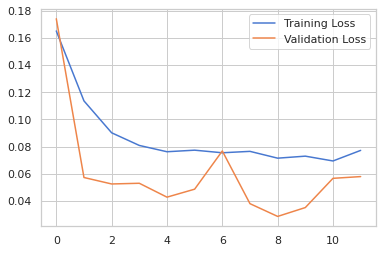

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [12]:
x_train_pred = model.predict(x_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(x_train_pred-x_train), axis=1), columns=['Error'])

In [13]:
model.evaluate(x_test, y_test)

51/51 [==============================] - 1s 16ms/step - loss: 0.3751


0.37514248490333557

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



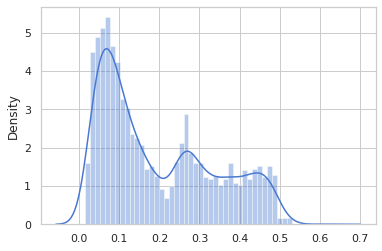

In [14]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [15]:
threshold=0.65

In [16]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred-x_test), axis=1)

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [17]:
test_score_df=pd.DataFrame(test[time_steps:])
test_score_df['loss']=test_mae_loss
test_score_df['threshold']=threshold
test_score_df['anomaly']=test_score_df.loss > test_score_df.threshold
test_score_df['close']=test[time_steps:].close

test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.056323,0.65,False
6584,2012-02-09,1.221625,0.056529,0.65,False
6585,2012-02-10,1.199313,0.056409,0.65,False
6586,2012-02-13,1.221194,0.056777,0.65,False
6587,2012-02-14,1.218150,0.055476,0.65,False


In [18]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,0.749862,0.65,True
8188,2018-06-26,4.507583,0.795215,0.65,True
8189,2018-06-27,4.451431,0.805319,0.65,True
8190,2018-06-28,4.491406,0.834757,0.65,True
8191,2018-06-29,4.496343,0.824146,0.65,True


In [19]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss, mode='lines', name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold, mode='lines', name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [22]:
anomalies = test_score_df[test_score_df.anomaly==True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.732199,0.65,True
7475,2015-08-26,2.632149,0.799208,0.65,True
7476,2015-08-27,2.745147,0.707884,0.65,True
7975,2017-08-21,3.801338,0.658719,0.65,True
7976,2017-08-22,3.859192,0.662664,0.65,True


In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date,y=scaler.inverse_transform(test[time_steps:].close),mode='lines',name='Close price'))
fig.add_trace(go.Scatter(x=anomalies.date,y=scaler.inverse_transform(anomalies.close),mode='markers',name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()